import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def f(x):
    return 3*x**2 - 4*x + 5

In [7]:
f(3.0)

20.0

In [10]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

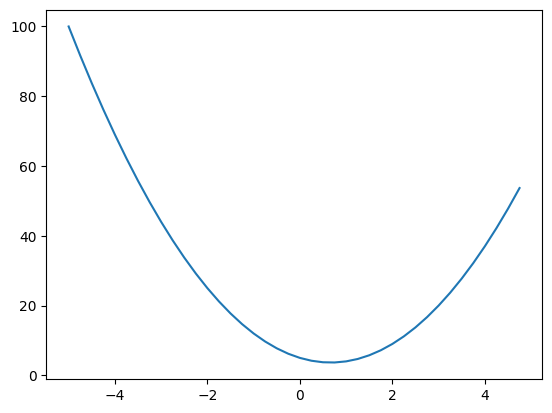

In [11]:
plt.plot(xs, ys)

In [26]:
h = 0.000000001
x = 2/3
(f(x + h) - f(x))/h

0.0

In [27]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [28]:
h = 0.0001

#input
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

a += h

d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)





d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [292]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward
            
        return out

    def __sub__(self, other):
        return self + (-other)

    def __neg__(self):
        return self * -1

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-8.0, grad=0.0)

In [293]:
2 * a

Value(data=4.0, grad=0.0)

In [224]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0, grad=0.0)

In [145]:
L._prev

{Value(data=-2.0), Value(data=4.0)}

In [91]:
L.grad

0.0

In [96]:

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

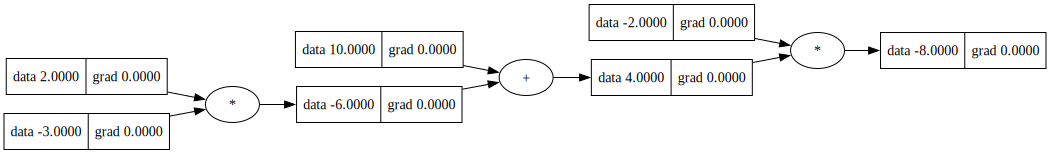

In [97]:
draw_dot(L)

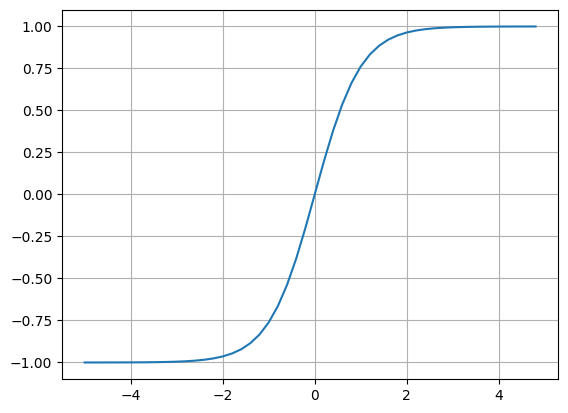

In [98]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

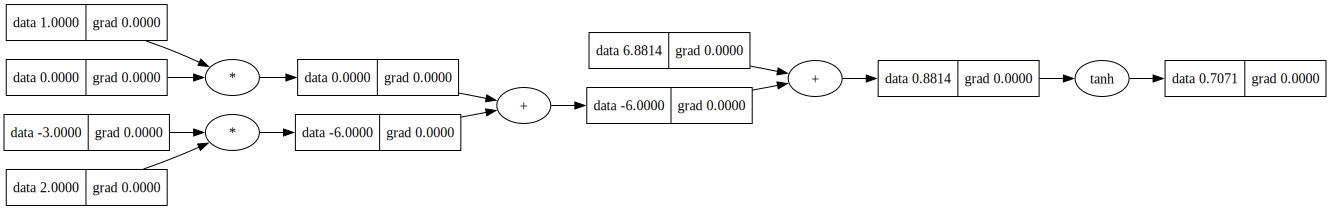

In [190]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()
draw_dot(o)

In [104]:
1 - o.data**2

0.5000000615321112

In [105]:
n.grad = 0.5

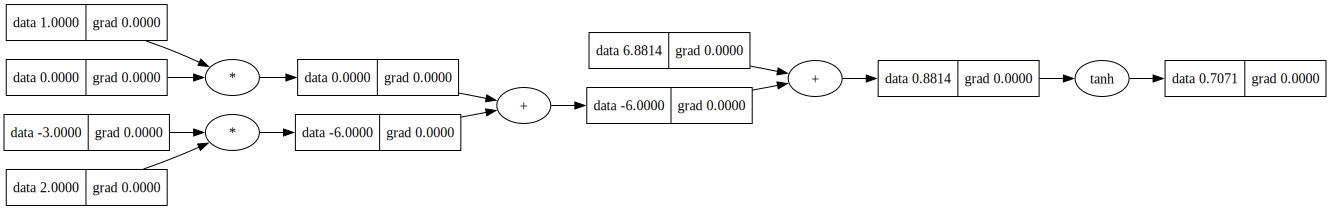

In [191]:
draw_dot(o)

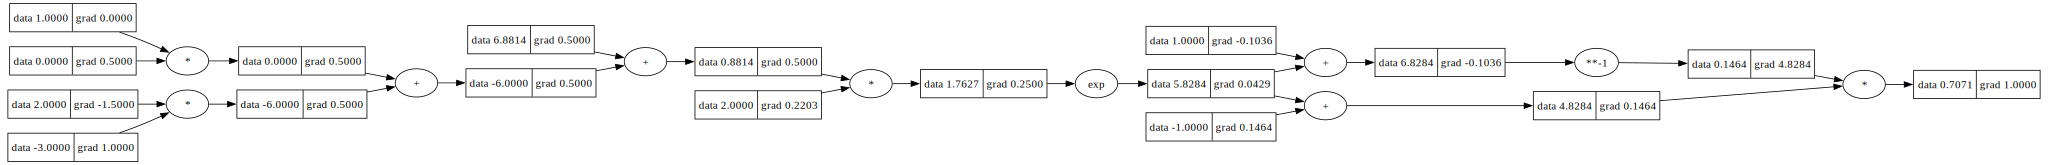

In [204]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e-1) / (e+1)
#o = n.tanh()
o.label = 'o'
o.backward()
draw_dot(o)

In [207]:
import torch

In [213]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88137]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071050214706146
x2 0.5000024886110417
w2 0.0
x1 -1.500007465833125
w1 1.0000049772220834


In [215]:
import random

In [362]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [367]:
n = MLP(3, [4, 4, 1])

In [368]:
len(n.parameters())

41

In [369]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]


In [380]:
for k in range(50):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    loss

    #zero grad
    for p in n.parameters(): 
        p.grad = 0.0
        
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.01 * p.grad

    print(k, loss.data)


0 0.007472448507204741
1 0.0074497509854980345
2 0.007427186466619232
3 0.007404753803481983
4 0.007382451862019433
5 0.007360279521001536
6 0.007338235671855046
7 0.007316319218486885
8 0.007294529077110175
9 0.007272864176073343
10 0.007251323455691946
11 0.007229905868083199
12 0.0072086103770034994
13 0.0071874359576882645
14 0.007166381596694716
15 0.007145446291746887
16 0.007124629051583495
17 0.007103928895808112
18 0.007083344854741635
19 0.0070628759692774705
20 0.007042521290738705
21 0.007022279880737859
22 0.0070021508110385735
23 0.006982133163419846
24 0.006962226029542251
25 0.006942428510816171
26 0.006922739718272419
27 0.006903158772434663
28 0.006883684803193901
29 0.006864316949685054
30 0.006845054360165307
31 0.006825896191894398
32 0.006806841611016979
33 0.006787889792446522
34 0.006769039919751144
35 0.00675029118504133
36 0.006731642788859108
37 0.006713093940069327
38 0.00669464385575203
39 0.006676291761097309
40 0.00665803688930078
41 0.006639878481461585
